In [ ]:
#Import Library
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
#from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import ADASYN
#from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#!pip install --upgrade scikit-learn
import sklearn

In [ ]:
# Load and preprocess data
data = pd.read_csv(r"/content/drive/MyDrive/Classifier_data.csv", sep='\t',encoding='utf-8',header=0)
data.head()

,Unnamed: 0,date,failure,serial_number,TARGET,GROUP,FAILURE_DATE,LogisticRegression :,DecisionTree :,RandomForest :,Naive Bayes :,KNeighbours :,SVM :,FAILURE_SN,Y_FAIL_LogisticRegression :,Y_FAIL_DecisionTree :,Y_FAIL_RandomForest :,Y_FAIL_Naive Bayes :,Y_FAIL_KNeighbours :,Y_FAIL_SVM :
0,0,2022-01-01,0,5PHRWLWD,1,TRAINING,2022-01-02,0.255573,0.285940,0.253204,1.0,0.271028,0.037031,1.0,1,1,1,1,1,0
1,1,2022-01-02,1,5PHRWLWD,1,TRAINING,2022-01-02,0.194518,0.285940,0.205996,1.0,0.289720,0.034738,1.0,0,1,0,1,1,0
2,2,2022-04-12,0,87DFWOGOT,1,TRAINING,2022-04-14,0.619367,0.527886,0.480340,1.0,0.401869,0.063685,1.0,1,1,1,1,1,0
3,3,2022-04-13,0,87DFWOGOT,1,TRAINING,2022-04-14,0.645816,0.527886,0.625039,1.0,0.401869,0.665248,1.0,1,1,1,1,1,1
4,4,2022-04-14,1,87DFWOGOT,1,TRAINING,2022-04-14,0.624512,0.527886,0.676527,1.0,0.383178,0.953289,1.0,1,1,1,1,1,1


In [ ]:
# Assuming 'df' is your DataFrame
columns_to_drop = [col for col in data.columns if col.startswith('Y_FAIL')]
data1 = data.drop(columns=columns_to_drop)
data1.head()

,Unnamed: 0,date,failure,serial_number,TARGET,GROUP,FAILURE_DATE,LogisticRegression :,DecisionTree :,RandomForest :,Naive Bayes :,KNeighbours :,SVM :,FAILURE_SN
0,0,2022-01-01,0,5PHRWLWD,1,TRAINING,2022-01-02,0.255573,0.285940,0.253204,1.0,0.271028,0.037031,1.0
1,1,2022-01-02,1,5PHRWLWD,1,TRAINING,2022-01-02,0.194518,0.285940,0.205996,1.0,0.289720,0.034738,1.0
2,2,2022-04-12,0,87DFWOGOT,1,TRAINING,2022-04-14,0.619367,0.527886,0.480340,1.0,0.401869,0.063685,1.0
3,3,2022-04-13,0,87DFWOGOT,1,TRAINING,2022-04-14,0.645816,0.527886,0.625039,1.0,0.401869,0.665248,1.0
4,4,2022-04-14,1,87DFWOGOT,1,TRAINING,2022-04-14,0.624512,0.527886,0.676527,1.0,0.383178,0.953289,1.0


In [ ]:


def threshold_failure_probability(df, classifier_columns, threshold=0.35):
    """
    Applies thresholding on the predicted probability columns of the provided dataframe for multiple classifiers.

    Parameters:
    - df (DataFrame): Input DataFrame with predicted probability columns for each classifier.
    - classifier_columns (list): List of columns containing predicted probabilities from different classifiers.
    - threshold (float): Probability threshold for failure.

    Returns:
    - DataFrame: DataFrame with added Y_FAIL columns for each classifier.
    """

    for column in classifier_columns:
        y_fail_column_name = 'Y_FAIL_' + column.split('_')[-1]  # Create a new column name based on classifier name
        df[y_fail_column_name] = np.where(df[column] <= threshold, 0, 1)

    return df

# Usage:
classifier_columns = ['LogisticRegression :','DecisionTree :','RandomForest :','Naive Bayes :','KNeighbours :','SVM :']  # List of classifier prediction columns
data3 = threshold_failure_probability(data1, classifier_columns)


In [ ]:
# Ground truth labels (your actual failures) in the DataFrame
actual_failures = data3['TARGET']

# Initialize dictionaries to store the evaluation results for each classifier
evaluation_results = {
    'Classifier': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Specificity': [],
    'Sensitivity': []
}

# List of Y_FAIL column names for each classifier
y_fail_columns = ['Y_FAIL_LogisticRegression :', 'Y_FAIL_DecisionTree :', 'Y_FAIL_RandomForest :','Y_FAIL_Naive Bayes :',
                  'Y_FAIL_KNeighbours :','Y_FAIL_SVM :']

# Calculate evaluation metrics for each classifier
for y_fail_column in y_fail_columns:
    # Extract predicted labels from the Y_FAIL column
    predicted_labels = data3[y_fail_column]

    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_failures, predicted_labels)
    roc_auc = roc_auc_score(actual_failures, predicted_labels)
    f1 = f1_score(actual_failures, predicted_labels,average='weighted')
    tn, fp, fn, tp = confusion_matrix(actual_failures, predicted_labels).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Store the results in the dictionary
    evaluation_results['Classifier'].append(y_fail_column.split('_')[-1])
    evaluation_results['Accuracy'].append(accuracy)
    evaluation_results['ROC AUC'].append(roc_auc)
    evaluation_results['F1 Score'].append(f1)
    evaluation_results['Specificity'].append(specificity)
    evaluation_results['Sensitivity'].append(sensitivity)

# Create a summary DataFrame with the evaluation results
evaluation_df = pd.DataFrame(evaluation_results)



In [ ]:
evaluation_df

,Classifier,Accuracy,ROC AUC,F1 Score,Specificity,Sensitivity
0,LogisticRegression :,0.948159,0.707024,0.947241,0.974601,0.439447
1,DecisionTree :,0.955890,0.655908,0.949541,0.988785,0.323031
2,RandomForest :,0.960923,0.723543,0.957771,0.986954,0.460132
3,Naive Bayes :,0.916041,0.779289,0.928534,0.931037,0.627541
4,KNeighbours :,0.955320,0.666154,0.949877,0.987029,0.345280
5,SVM :,0.956776,0.632260,0.948251,0.992361,0.272159


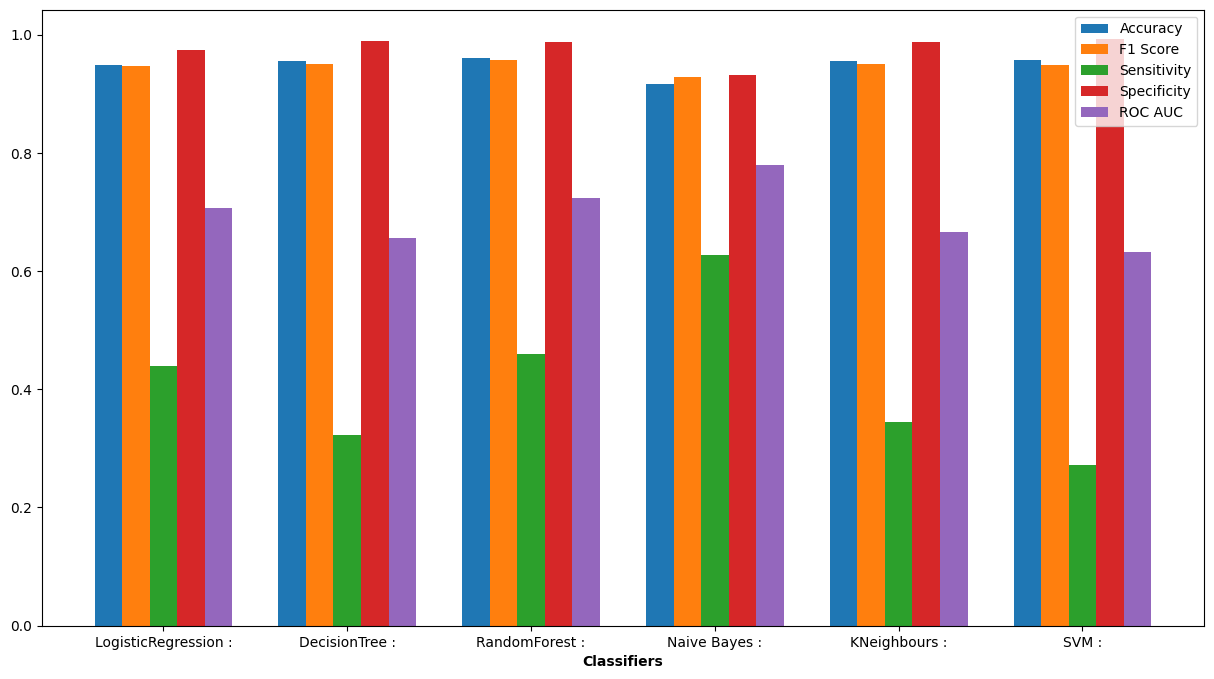

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers and metrics
classifiers_names = evaluation_df['Classifier']
metrics_data = {
    'Accuracy': evaluation_df['Accuracy'],
    'F1 Score': evaluation_df['F1 Score'],
    'Sensitivity': evaluation_df['Sensitivity'],
    'Specificity': evaluation_df['Specificity'],
    'ROC AUC': evaluation_df['ROC AUC']
}

# Set the bar plot parameters
barWidth = 0.15
r = np.arange(len(classifiers_names))

# Create a figure
plt.figure(figsize=(15, 8))

# Iterate through each metric and create a bar plot
for i, metric in enumerate(metrics_data.keys()):
    plt.bar([x + i * barWidth for x in r], metrics_data[metric], width=barWidth, label=metric)

plt.xlabel('Classifiers', fontweight='bold')
plt.xticks([r + 2 * barWidth for r in range(len(classifiers_names))], classifiers_names)
plt.legend()
plt.show()


In [ ]:
def clean_data_multi(df, forecast_window=10, classifier_columns=[]):
    # Sort the data by 'ID' and 'DATE'
    df = df.sort_values(by=['serial_number', 'date'], ascending=[True, True])

    # Assign unique index for each 'ID'
    pd_id = df.drop_duplicates(subset='serial_number')[['serial_number']].reset_index(drop=True).reset_index(drop=False)
    pd_id = pd_id.rename(columns={"index": "UniqueDiskIndex"})
    pd_id['UniqueDiskIndex'] = pd_id['UniqueDiskIndex'] + 1
    max_value = pd_id["UniqueDiskIndex"].max()

    # Merge with the main dataframe
    df = df.merge(pd_id, on=['serial_number'], how='inner').sort_values(by=['serial_number', 'date'])

    # Process each classifier's Y_FAIL column
    for col in classifier_columns:
        # Placeholder for rolling sum
        df[f'{col}_sumxx'] = 0

        results = []
        for x in range(1, max_value+1):
            dff = df[df['UniqueDiskIndex'] == x].copy()
            dff[f'{col}_sumxx'] = dff[col].rolling(min_periods=1, window=forecast_window).sum()
            results.append(dff)

        df_temp = pd.concat(results)
        df[f'{col}_Z'] = np.where(df_temp[f'{col}_sumxx'] > 1, 0, df_temp[col])

    # Cleanup and return
    for col in classifier_columns:
        df = df.drop([f'{col}_sumxx'], axis=1, errors='ignore')

    df = df.drop(['UniqueDiskIndex'], axis=1, errors='ignore')
    return df


classifier_columns = ['Y_FAIL_LogisticRegression :','Y_FAIL_DecisionTree :','Y_FAIL_RandomForest :','Y_FAIL_Naive Bayes :','Y_FAIL_KNeighbours :','Y_FAIL_SVM :']

data4 = clean_data_multi(data, classifier_columns=classifier_columns)


In [ ]:
# Ground truth labels (your actual failures) in the DataFrame
#actual_failures = data4['TARGET']

# Initialize dictionaries to store the evaluation results for each classifier
evaluation_results = {
    'Classifier': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Specificity': [],
    'Sensitivity': []
}

# List of Y_FAIL column names for each classifier
y_fail_columns = ['Y_FAIL_LogisticRegression :_Z', 'Y_FAIL_DecisionTree :_Z', 'Y_FAIL_RandomForest :_Z','Y_FAIL_Naive Bayes :_Z',
                  'Y_FAIL_KNeighbours :_Z','Y_FAIL_SVM :_Z']

# Calculate evaluation metrics for each classifier
for y_fail_column in y_fail_columns:
    # Extract predicted labels from the Y_FAIL column
    predicted_labels = data4[y_fail_column]

    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_failures, predicted_labels)
    roc_auc = roc_auc_score(actual_failures, predicted_labels)
    f1 = f1_score(actual_failures, predicted_labels,average='weighted')
    tn, fp, fn, tp = confusion_matrix(actual_failures, predicted_labels).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Store the results in the dictionary
    evaluation_results['Classifier'].append(y_fail_column.split('_')[2].split(' :')[0])
    evaluation_results['Accuracy'].append(accuracy)
    evaluation_results['ROC AUC'].append(roc_auc)
    evaluation_results['F1 Score'].append(f1)
    evaluation_results['Specificity'].append(specificity)
    evaluation_results['Sensitivity'].append(sensitivity)

# Create a summary DataFrame with the evaluation results
evaluation1_df = pd.DataFrame(evaluation_results)



In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import pandas as pd

# Ground truth labels (your actual failures) in the DataFrame
actual_failures = data4['TARGET']

# Initialize dictionaries to store the evaluation results for each classifier
evaluation_results = {
    'Classifier': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Specificity': [],
    'Sensitivity': [],
    'True Positives': [],
    'True Negatives': [],
    'False Positives': [],
    'False Negatives': []
}

# List of Y_FAIL column names for each classifier
y_fail_columns = ['Y_FAIL_LogisticRegression :_Z', 'Y_FAIL_DecisionTree :_Z', 'Y_FAIL_RandomForest :_Z','Y_FAIL_Naive Bayes :_Z',
                  'Y_FAIL_KNeighbours :_Z','Y_FAIL_SVM :_Z']

# Calculate evaluation metrics for each classifier
for y_fail_column in y_fail_columns:
    # Extract predicted labels from the Y_FAIL column
    predicted_labels = data4[y_fail_column]

    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_failures, predicted_labels)
    roc_auc = roc_auc_score(actual_failures, predicted_labels)
    f1 = f1_score(actual_failures, predicted_labels, average='weighted')
    tn, fp, fn, tp = confusion_matrix(actual_failures, predicted_labels).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Store the results in the dictionary
    evaluation_results['Classifier'].append(y_fail_column.split('_')[2].split(' :')[0])
    evaluation_results['Accuracy'].append(accuracy)
    evaluation_results['ROC AUC'].append(roc_auc)
    evaluation_results['F1 Score'].append(f1)
    evaluation_results['Specificity'].append(specificity)
    evaluation_results['Sensitivity'].append(sensitivity)
    evaluation_results['True Positives'].append(tp)
    evaluation_results['True Negatives'].append(tn)
    evaluation_results['False Positives'].append(fp)
    evaluation_results['False Negatives'].append(fn)

# Create a summary DataFrame with the evaluation results
evaluation1_df = pd.DataFrame(evaluation_results)


In [ ]:
evaluation1_df

,Classifier,Accuracy,ROC AUC,F1 Score,Specificity,Sensitivity,True Positives,True Negatives,False Positives,False Negatives
0,LogisticRegression,0.946418,0.527107,0.929396,0.992399,0.061816,514,158754,1216,7801
1,DecisionTree,0.945319,0.524420,0.928433,0.991473,0.057366,477,158606,1364,7838
2,RandomForest,0.946490,0.527031,0.929420,0.992486,0.061575,512,158768,1202,7803
3,Naive Bayes,0.945872,0.525908,0.928937,0.991923,0.059892,498,158678,1292,7817
4,KNeighbours,0.946935,0.529716,0.930056,0.992686,0.066747,555,158800,1170,7760
5,SVM,0.951368,0.516485,0.930044,0.999056,0.033915,282,159819,151,8033


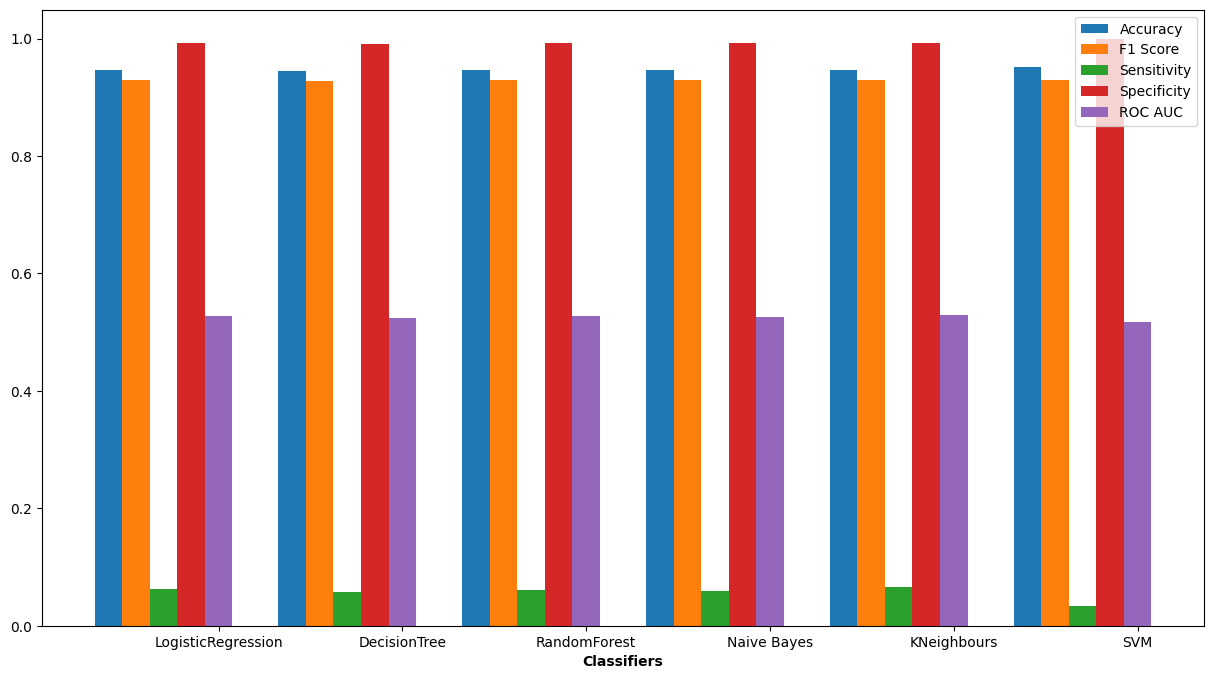

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers and metrics
classifiers_names = evaluation1_df['Classifier']
metrics_data = {
    'Accuracy': evaluation1_df['Accuracy'],
    'F1 Score': evaluation1_df['F1 Score'],
    'Sensitivity': evaluation1_df['Sensitivity'],
    'Specificity': evaluation1_df['Specificity'],
    'ROC AUC': evaluation1_df['ROC AUC']
}

# Set the bar plot parameters
barWidth = 0.15
r = np.arange(len(classifiers_names))

# Create a figure
plt.figure(figsize=(15, 8))

# Iterate through each metric and create a bar plot
for i, metric in enumerate(metrics_data.keys()):
    plt.bar([x + i * barWidth for x in r], metrics_data[metric], width=barWidth, label=metric)

plt.xlabel('Classifiers', fontweight='bold')
plt.xticks([r + 4 * barWidth for r in range(len(classifiers_names))], classifiers_names)
plt.legend()
plt.show()


In [ ]:
import pandas as pd

def preprocess_and_create_signal_ids(df, classifier_columns):
    """
    Preprocess the DataFrame and create signal_id columns for each classifier column.

    Parameters:
    - df (DataFrame): Input DataFrame.
    - classifier_columns (list): List of classifier columns.

    Returns:
    - DataFrame: Preprocessed DataFrame with signal_id columns.
    """
    # Sort the DataFrame based on serial_number and date
    sorted_df = df.sort_values(by=['serial_number', 'date'], ascending=[True, True])

    # Create signal_id columns for each classifier column
    for col in classifier_columns:
        signal_col_name = col.replace("Y_FAIL_", "SIGNAL_ID_")
        sorted_df[signal_col_name] = sorted_df[col].cumsum()

    return sorted_df



# Preprocess the DataFrame and create signal_id columns
data5 = preprocess_and_create_signal_ids(data4, classifier_columns)


In [ ]:
# Dictionary to hold dataframes for each classifier
dfs_by_classifier = {}

for col in classifier_columns:
    # Create a deep copy of sorted_df to ensure original data is not modified
    df_classifier = data5.copy()

    # Create a unique SIGNAL_ID for the classifier
    signal_col_name = col.replace("Y_FAIL_", "SIGNAL_ID_")
    df_classifier[signal_col_name] = df_classifier[col].cumsum()

    # Filter signals for this classifier
    df_signals = df_classifier[df_classifier[col] == 1]
    df_signal_date = df_signals[[signal_col_name, 'date', 'serial_number']]

    df_signal_date = df_signal_date.rename(columns={
        signal_col_name: "SIGNAL_ID",  # Use generic SIGNAL_ID for merging
        "date": "SIGNAL_DATE",
        "serial_number": "ID_OF_SIGNAL"
    })

    # Rename the classifier-specific SIGNAL_ID in df_classifier to generic SIGNAL_ID
    df_classifier.rename(columns={signal_col_name: "SIGNAL_ID"}, inplace=True)

    # Merge the classifier-specific signal dates back with df_classifier
    df_classifier = df_classifier.merge(df_signal_date, on="SIGNAL_ID", how='outer')

    # Drop all other classifier columns and related columns except for the current one
    other_classifiers = [c for c in classifier_columns if c != col]
    drop_columns = other_classifiers.copy()  # Starts with the raw output columns of other classifiers

    # Add the Z and SIGNAL_ID columns of other classifiers to the drop list
    for other_col in other_classifiers:
        drop_columns.extend([
            other_col + "_Z",
            "SIGNAL_ID_" + other_col.replace("Y_FAIL_", "")
        ])

    df_classifier.drop(columns=drop_columns, inplace=True, errors='ignore')

    # Convert FAILURE_DATE and SIGNAL_DATE to datetime, then calculate WARNING
    df_classifier['FAILURE_DATE'] = pd.to_datetime(df_classifier['FAILURE_DATE'])
    df_classifier['SIGNAL_DATE'] = pd.to_datetime(df_classifier['SIGNAL_DATE'])
    df_classifier['C'] = df_classifier['FAILURE_DATE'] - df_classifier['SIGNAL_DATE']
    df_classifier['WARNING'] = df_classifier['C'] / np.timedelta64(1, 'D')

    # Drop the intermediate column 'C'
    df_classifier.drop(columns=['C'], inplace=True, errors='ignore')
    # Store the dataframe in the dictionary using the classifier's name as the key
    dfs_by_classifier[col] = df_classifier

# dfs_by_classifier now contains separate dataframes for each classifier.


In [ ]:
df_logistic_regression2 = dfs_by_classifier['Y_FAIL_LogisticRegression :']
df_logistic_regression2.head()

,Unnamed: 0,date,failure,serial_number,TARGET,GROUP,FAILURE_DATE,LogisticRegression :,DecisionTree :,RandomForest :,Naive Bayes :,KNeighbours :,SVM :,FAILURE_SN,Y_FAIL_LogisticRegression :,Y_FAIL_LogisticRegression :_Z,SIGNAL_ID,SIGNAL_DATE,ID_OF_SIGNAL,WARNING
0,150541,2022-01-01,0,1040A01ZF97G,0,VALIDATION,2099-12-12,0.017969,0.014693,0.010383,5.226736e-91,0.0,0.037582,0.0,0,0,0,NaT,NaN,NaN
1,150543,2022-01-02,0,1040A01ZF97G,0,VALIDATION,2099-12-12,0.017943,0.014693,0.010383,5.065024e-91,0.0,0.037584,0.0,0,0,0,NaT,NaN,NaN
2,150539,2022-01-03,0,1040A01ZF97G,0,VALIDATION,2099-12-12,0.017993,0.014693,0.010383,5.339012e-91,0.0,0.037594,0.0,0,0,0,NaT,NaN,NaN
3,150531,2022-01-04,0,1040A01ZF97G,0,VALIDATION,2099-12-12,0.017905,0.014693,0.010588,5.009839e-91,0.0,0.037567,0.0,0,0,0,NaT,NaN,NaN
4,150535,2022-01-05,0,1040A01ZF97G,0,VALIDATION,2099-12-12,0.017974,0.014693,0.010383,5.165016e-91,0.0,0.037579,0.0,0,0,0,NaT,NaN,NaN


from matplotlib import pyplot as plt
_df_0['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['LogisticRegression :'].plot(kind='hist', bins=20, title='LogisticRegression :')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['RandomForest :'].plot(kind='hist', bins=20, title='RandomForest :')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Naive Bayes :'].plot(kind='hist', bins=20, title='Naive Bayes :')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Unnamed: 0', y='LogisticRegression :', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='LogisticRegression :', y='RandomForest :', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='RandomForest :', y='Naive Bayes :', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Naive Bayes :', y='SVM :', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Unnamed: 0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Unnamed: 0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['LogisticRegression :']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('LogisticRegression :')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['RandomForest :']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('RandomForest :')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Naive Bayes :']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Naive Bayes :')

from matplotlib import pyplot as plt
_df_13['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['LogisticRegression :'].plot(kind='line', figsize=(8, 4), title='LogisticRegression :')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['RandomForest :'].plot(kind='line', figsize=(8, 4), title='RandomForest :')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Naive Bayes :'].plot(kind='line', figsize=(8, 4), title='Naive Bayes :')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Unnamed: 0', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='LogisticRegression :', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='RandomForest :', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Naive Bayes :', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

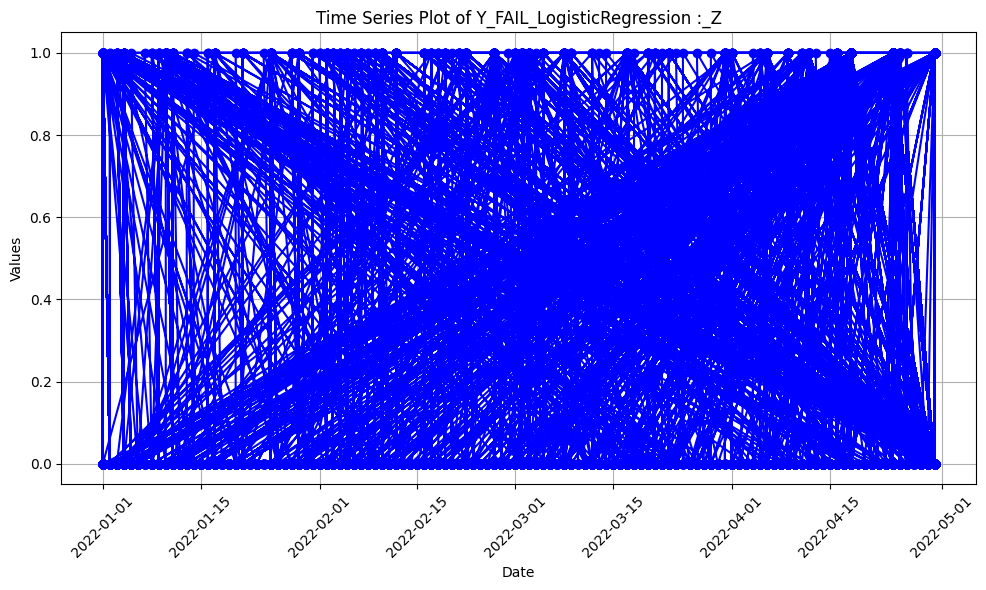

In [ ]:
# Column to plot
date_column = 'SIGNAL_DATE'
value_column = 'Y_FAIL_LogisticRegression :_Z'

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(df_logistic_regression2[date_column], df_logistic_regression2[value_column], marker='o', linestyle='-', color='b')

# Customize the plot (add labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(f'Time Series Plot of {value_column}')
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [ ]:
df_DecisionTree2 = dfs_by_classifier['Y_FAIL_DecisionTree :']
df_RandomForest2 = dfs_by_classifier['Y_FAIL_RandomForest :']
df_NaiveBayes2 = dfs_by_classifier['Y_FAIL_Naive Bayes :']
df_KNeighbours2 = dfs_by_classifier['Y_FAIL_KNeighbours :']
df_SVM2 = dfs_by_classifier['Y_FAIL_SVM :']

In [ ]:
def compute_and_aggregate_predictions(df, forecast_window=15):
    """
    This function categorizes equipment failure predictions into True Positive,
    False Positive, False Negative, and True Negative.
    It then aggregates these categories based on MODELING_GROUP.

    Parameters:
    - df (DataFrame): Input dataframe
    - forecast_window (int): Duration for forecast. Default is 15.

    Returns:
    - DataFrame: Aggregated results based on MODELING_GROUP
    """
    # Define a True Positive
    df['TRUE_POSITIVE'] = np.where(
        (df['failure'] == 1) &
        (df['WARNING'] <= forecast_window) &
        (df['WARNING'] >= 0) &
        (df['ID_OF_SIGNAL'] == df['serial_number']),
        1, 0
    )

    # Define a False Negative
    df['FALSE_NEGATIVE'] = np.where(
        #(df['TRUE_POSITIVE'] == 0) &
        (df['Y_FAIL_SVM :_Z'] == 0) &
        (df['failure'] == 1),
        1, 0
    )

    # Determine invalid warning signals
    df['INVALID_SIGNAL'] = np.where(
        (df['WARNING'] < 0) |
        (df['WARNING'] >= forecast_window) |
        df['WARNING'].isnull(),
        1, 0
    )

    # Define a False Positive
    df['FALSE_POSITIVE'] = np.where(
        (df['Y_FAIL_SVM :_Z'] == 1) &
        (df['INVALID_SIGNAL'] == 1) &
        (df['ID_OF_SIGNAL'] == df['serial_number']),
        1, 0
    )

    # Define a True Negative
    df['TRUE_NEGATIVE'] = np.where(
        (df['FALSE_POSITIVE'] == 0) &
        (df['TRUE_POSITIVE'] == 0) &
        (df['FALSE_NEGATIVE'] == 0),
        1, 0
    )

    # Categorize the results
    df['CATEGORY'] = np.where(
        df['FALSE_POSITIVE'] == 1, 'FALSE_POSITIVE',
        np.where(
            df['FALSE_NEGATIVE'] == 1, 'FALSE_NEGATIVE',
            np.where(
                df['TRUE_POSITIVE'] == 1, 'TRUE_POSITIVE',
                'TRUE_NEGATIVE'
            )
        )
    )

    # Aggregate the results by MODELING_GROUP
    aggregated_results = df.groupby('GROUP').aggregate(
        {
            'FALSE_POSITIVE': 'sum',
            'TRUE_POSITIVE': 'sum',
            'FALSE_NEGATIVE': 'sum',
            'TRUE_NEGATIVE': 'sum'
        }
    )

    return aggregated_results




In [ ]:
df_SVM1 = compute_and_aggregate_predictions(df_SVM2)
df_SVM1.head()

,FALSE_POSITIVE,TRUE_POSITIVE,FALSE_NEGATIVE,TRUE_NEGATIVE
GROUP,,,,
TESTING,35,131,269,54893
TRAINING,28,144,258,54465
VALIDATION,27,128,254,58050


In [ ]:
def compute_and_aggregate_predictions(df, forecast_window=15):
    """
    This function categorizes equipment failure predictions into True Positive,
    False Positive, False Negative, and True Negative.
    It then aggregates these categories based on MODELING_GROUP.

    Parameters:
    - df (DataFrame): Input dataframe
    - forecast_window (int): Duration for forecast. Default is 15.

    Returns:
    - DataFrame: Aggregated results based on MODELING_GROUP
    """
    # Define a True Positive
    df['TRUE_POSITIVE'] = np.where(
        (df['failure'] == 1) &
        (df['WARNING'] <= forecast_window) &
        (df['WARNING'] >= 0) &
        (df['ID_OF_SIGNAL'] == df['serial_number']),
        1, 0
    )

    # Define a False Negative
    df['FALSE_NEGATIVE'] = np.where(
        (df['TRUE_POSITIVE'] == 0) &
        (df['failure'] == 1),
        1, 0
    )

    # Determine invalid warning signals
    df['INVALID_SIGNAL'] = np.where(
        (df['WARNING'] < 0) |
        (df['WARNING'] >= forecast_window) |
        df['WARNING'].isnull(),
        1, 0
    )

    # Define a False Positive
    df['FALSE_POSITIVE'] = np.where(
        (df['Y_FAIL_SVM :_Z'] == 1) &
        (df['INVALID_SIGNAL'] == 1) &
        (df['ID_OF_SIGNAL'] == df['serial_number']),
        1, 0
    )

    # Define a True Negative
    df['TRUE_NEGATIVE'] = np.where(
        (df['FALSE_POSITIVE'] == 0) &
        (df['TRUE_POSITIVE'] == 0) &
        (df['FALSE_NEGATIVE'] == 0),
        1, 0
    )

    # Categorize the results
    df['CATEGORY'] = np.where(
        df['FALSE_POSITIVE'] == 1, 'FALSE_POSITIVE',
        np.where(
            df['FALSE_NEGATIVE'] == 1, 'FALSE_NEGATIVE',
            np.where(
                df['TRUE_POSITIVE'] == 1, 'TRUE_POSITIVE',
                'TRUE_NEGATIVE'
            )
        )
    )

    # Aggregate the results by MODELING_GROUP
    aggregated_results = df.groupby('GROUP').aggregate(
        {
            'FALSE_POSITIVE': 'sum',
            'TRUE_POSITIVE': 'sum',
            'FALSE_NEGATIVE': 'sum',
            'TRUE_NEGATIVE': 'sum'
        }
    )

    return aggregated_results




In [ ]:
df_SVM1 = compute_and_aggregate_predictions(df_SVM2)
df_SVM1.head()

,FALSE_POSITIVE,TRUE_POSITIVE,FALSE_NEGATIVE,TRUE_NEGATIVE
GROUP,,,,
TESTING,40,131,139,54888
TRAINING,29,144,117,54464
VALIDATION,28,128,128,58049


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def calculate_metrics(df):
    # Extract values for each group
    group_names = df.index
    tp = df['TRUE_POSITIVE']
    fp = df['FALSE_POSITIVE']
    fn = df['FALSE_NEGATIVE']
    tn = df['TRUE_NEGATIVE']

    # Calculate F1 Score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("F1 Score:")
    print(f1_score)


    # Calculate Sensitivity and Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("Sensitivity (Recall):")
    print(sensitivity)
    print("Specificity:")
    print(specificity)

    # Calculate Accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    print("Accuracy:")
    print(accuracy)






In [ ]:
calculate_metrics(df_SVM1)

F1 Score:
GROUP
TESTING       0.594104
TRAINING      0.663594
VALIDATION    0.621359
dtype: float64
Sensitivity (Recall):
GROUP
TESTING       0.485185
TRAINING      0.551724
VALIDATION    0.500000
dtype: float64
Specificity:
GROUP
TESTING       0.999272
TRAINING      0.999468
VALIDATION    0.999518
dtype: float64
Accuracy:
GROUP
TESTING       0.996757
TRAINING      0.997334
VALIDATION    0.997326
dtype: float64


In [ ]:
calculate_metrics(df_logistic_regression1)

F1 Score:
GROUP
TESTING       0.595745
TRAINING      0.591484
VALIDATION    0.566332
dtype: float64
Sensitivity (Recall):
GROUP
TESTING       0.985185
TRAINING      0.984674
VALIDATION    0.992188
dtype: float64
Specificity:
GROUP
TESTING       0.993501
TRAINING      0.993559
VALIDATION    0.993336
dtype: float64
Accuracy:
GROUP
TESTING       0.993460
TRAINING      0.993516
VALIDATION    0.993331
dtype: float64


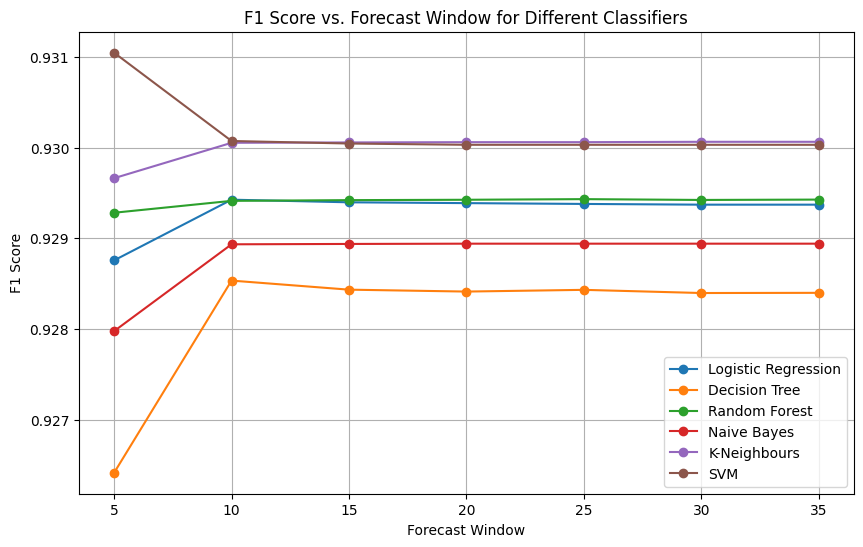

In [ ]:
import matplotlib.pyplot as plt

# Define the data
forecast_window = [5, 10, 15, 20, 25, 30, 35]
logistic_regression = [0.928756, 0.929425, 0.929396, 0.929387, 0.929378, 0.929370, 0.929370]
decision_tree = [0.926415, 0.928533, 0.928433, 0.928412, 0.928431, 0.928396, 0.928398]
random_forest = [0.929281, 0.929412, 0.929420, 0.929424, 0.929431, 0.929422, 0.929426]
naive_bayes = [0.927976, 0.928933, 0.928937, 0.928940, 0.928940, 0.928940, 0.928940]
k_neighbors = [0.929662, 0.930052, 0.930056, 0.930059, 0.930059, 0.930063, 0.930063]
svm = [0.931045, 0.930072, 0.930044, 0.930030, 0.930030, 0.930030, 0.930030]

# Create the line graph
plt.figure(figsize=(10, 6))

plt.plot(forecast_window, logistic_regression, label='Logistic Regression', marker='o')
plt.plot(forecast_window, decision_tree, label='Decision Tree', marker='o')
plt.plot(forecast_window, random_forest, label='Random Forest', marker='o')
plt.plot(forecast_window, naive_bayes, label='Naive Bayes', marker='o')
plt.plot(forecast_window, k_neighbors, label='K-Neighbours', marker='o')
plt.plot(forecast_window, svm, label='SVM', marker='o')

plt.title('F1 Score vs. Forecast Window for Different Classifiers')
plt.xlabel('Forecast Window')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


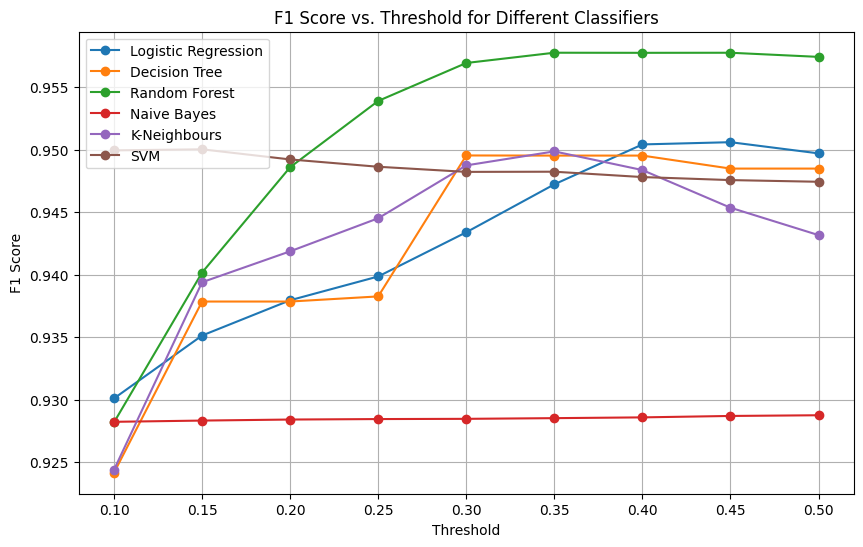

In [ ]:
import matplotlib.pyplot as plt

# Define the data
threshold = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
logistic_regression = [0.930113, 0.935144, 0.937967, 0.939870, 0.943406, 0.947241, 0.950434, 0.950613, 0.949718]
decision_tree = [0.924168, 0.937864, 0.937864, 0.938274, 0.949551, 0.949541, 0.949541, 0.948501, 0.948501]
random_forest = [0.928198, 0.940183, 0.948611, 0.953913, 0.956950, 0.957771, 0.957763, 0.957769, 0.957438]
naive_bayes = [0.928241, 0.928340, 0.928423, 0.928461, 0.928479, 0.928534, 0.928596, 0.928710, 0.928766]
k_neighbors = [0.924400, 0.939408, 0.941882, 0.944527, 0.948757, 0.949877, 0.948382, 0.945371, 0.943179]
svm = [0.949958, 0.950043, 0.949233, 0.948647, 0.948237, 0.948251, 0.947823, 0.947581, 0.947446]

# Create the line graph
plt.figure(figsize=(10, 6))

plt.plot(threshold, logistic_regression, label='Logistic Regression', marker='o')
plt.plot(threshold, decision_tree, label='Decision Tree', marker='o')
plt.plot(threshold, random_forest, label='Random Forest', marker='o')
plt.plot(threshold, naive_bayes, label='Naive Bayes', marker='o')
plt.plot(threshold, k_neighbors, label='K-Neighbours', marker='o')
plt.plot(threshold, svm, label='SVM', marker='o')

plt.title('F1 Score vs. Threshold for Different Classifiers')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
